# Introduction

In this project, I will clean, explore, and analyze the `twitter_corpus` dataset created by Sanders Analytics. This dataset includes tweets labeled with sentiments across different topics. The primary objectives are to understand the distribution of sentiments, identify common topics, and explore tweet characteristics over time.

The main steps taken in this project are:
1. Importing libraries and setting up the environment.
2. Loading and exploring the dataset.
3. Cleaning and preparing the data for analysis.
4. Visualizing and analyzing the data to uncover key insights.
5. Summarizing key findings and drawing conclusions from the analysis.

# Setup and Imports

In this section, I will import the necessary libraries and set up the environment for the analysis. This includes installing required packages and importing Python libraries that will help me with data manipulation, visualization, and analysis.

In [28]:
%%capture
# Install necessary packages
!pip install pandas numpy matplotlib seaborn langdetect wordcloud textblob

# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from langdetect import detect
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Set visualization style
sns.set(style="whitegrid")

# Social Media Data

Initially, I was supposed to generate random data for social media usage, but instead decided to work with the `twitter_corpus` dataset created by Sanders Analytics. This real dataset provides more valuable insights and practical experience. Although using the X API for live data was considered, I decided not to invest $100 into this project.

The `twitter_corpus` dataset contains hand-classified tweets with sentiment labels across different topics. For this analysis, I will work with the complete dataset, containing 5113 tweets, available at [Twitter Corpus GitHub](https://github.com/zfz/twitter_corpus).

# Data Loading

In this section, I will load the social media data into a Pandas dataframe and explore it. This involves reading the data from a CSV file, displaying basic information about the dataset, and viewing the first few rows to understand its structure.

In [29]:
# Data Loading
url = "https://raw.githubusercontent.com/zfz/twitter_corpus/master/full-corpus.csv"
df_tweets = pd.read_csv(url, encoding='latin-1')

# Display basic information about the dataset
print(df_tweets.info())
print(df_tweets.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5113 entries, 0 to 5112
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Topic      5113 non-null   object
 1   Sentiment  5113 non-null   object
 2   TweetId    5113 non-null   int64 
 3   TweetDate  5113 non-null   object
 4   TweetText  5113 non-null   object
dtypes: int64(1), object(4)
memory usage: 199.9+ KB
None
   Topic Sentiment             TweetId                       TweetDate  \
0  apple  positive  126415614616154112  Tue Oct 18 21:53:25 +0000 2011   
1  apple  positive  126404574230740992  Tue Oct 18 21:09:33 +0000 2011   
2  apple  positive  126402758403305474  Tue Oct 18 21:02:20 +0000 2011   
3  apple  positive  126397179614068736  Tue Oct 18 20:40:10 +0000 2011   
4  apple  positive  126395626979196928  Tue Oct 18 20:34:00 +0000 2011   

                                           TweetText  
0  Now all @Apple has to do is get swype on the i...  
1  @Apple

# Data Cleaning and Preparation

In this section, I will clean and prepare the data for analysis. This involves removing duplicates, handling missing values, filtering for English tweets, excluding tweets longer than 140 characters, removing non-ASCII tweets, extracting data, converting date columns to datetime, and generating new columns.

## Cleaning

Steps taken to clean the data:
- Remove duplicates
- Handle missing values
- Filter for English tweets
- Exclude tweets longer than 140 characters
- Remove non-ASCII tweets

In [30]:
# Define function to detect language
def detect_language(text):
    try:
        return detect(text)
    except:
        return None

# Remove duplicates
df_tweets.drop_duplicates(inplace=True)

# Verify no duplicates are present
print(f"Number of duplicate rows: {df_tweets.duplicated().sum()}")

# Check for missing values
print("Missing values in each column:")
print(df_tweets.isnull().sum())

# Detect and filter English tweets
df_tweets['Language'] = df_tweets['TweetText'].apply(detect_language)
df_english_tweets = df_tweets[df_tweets['Language'] == 'en'].copy()

# Drop the 'Language' column as it's no longer needed
df_english_tweets.drop(columns=['Language'], inplace=True)

# Exclude tweets longer than 140 characters
df_english_tweets = df_english_tweets[df_english_tweets['TweetText'].apply(len) <= 140]

# Exclude non-ASCII tweets
df_english_tweets = df_english_tweets[df_english_tweets['TweetText'].apply(lambda x: all(ord(char) < 128 for char in x))]

# Display the first few rows of the cleaned dataset
print("Info of the cleaned dataset:")
print(df_english_tweets.info())
print("First few rows of the cleaned dataset:")
print(df_english_tweets.head())

# Save the cleaned dataset
df_english_tweets.to_csv('english_tweets.csv', index=False)

Number of duplicate rows: 0
Missing values in each column:
Topic        0
Sentiment    0
TweetId      0
TweetDate    0
TweetText    0
dtype: int64
Info of the cleaned dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 3364 entries, 0 to 5102
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Topic      3364 non-null   object
 1   Sentiment  3364 non-null   object
 2   TweetId    3364 non-null   int64 
 3   TweetDate  3364 non-null   object
 4   TweetText  3364 non-null   object
dtypes: int64(1), object(4)
memory usage: 157.7+ KB
None
First few rows of the cleaned dataset:
   Topic Sentiment             TweetId                       TweetDate  \
0  apple  positive  126415614616154112  Tue Oct 18 21:53:25 +0000 2011   
1  apple  positive  126404574230740992  Tue Oct 18 21:09:33 +0000 2011   
2  apple  positive  126402758403305474  Tue Oct 18 21:02:20 +0000 2011   
3  apple  positive  126397179614068736  Tue Oct 18 20:40:1

## Preparation

In this step, I will prepare our cleaned data for analysis and visualization. This involves generating sentiment scores, extracting hashtags and mentions, and converting date formats. These transformations ensure the data is ready for exploratory data analysis.

Steps taken to prepare the data:
- Generate sentiment scores
- Extract hashtags
- Extract mentions
- Convert date columns to datetime
- Create new columns for date, hour, and day of the week
- Calculate tweet length

In [34]:
# Define functions for later use
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

def extract_hashtags(text):
    return [word for word in text.split() if word.startswith('#')]

def extract_mentions(text):
    return [word for word in text.split() if word.startswith('@')]

# Generate sentiment scores
df_english_tweets['SentimentScore'] = df_english_tweets['TweetText'].apply(get_sentiment)

# Extract hashtags
df_english_tweets['Hashtags'] = df_english_tweets['TweetText'].apply(extract_hashtags)

# Extract mentions
df_english_tweets['Mentions'] = df_english_tweets['TweetText'].apply(extract_mentions)

# Convert 'TweetDate' to datetime
df_english_tweets['TweetDate'] = pd.to_datetime(df_english_tweets['TweetDate'], format='%a %b %d %H:%M:%S %z %Y', errors='coerce')

# Create new columns for date, hour, and day of the week
df_english_tweets['Date'] = df_english_tweets['TweetDate'].dt.date
df_english_tweets['Hour'] = df_english_tweets['TweetDate'].dt.hour
df_english_tweets['Day'] = df_english_tweets['TweetDate'].dt.day_name()

# Calculate Tweet Length
df_english_tweets['TweetLength'] = df_english_tweets['TweetText'].apply(len)

# Ensure the dataframe is sorted by 'TweetDate'
df_english_tweets = df_english_tweets.sort_values(by='TweetDate')

# Display the first few rows of the cleaned and processed dataset
display(df_english_tweets.head())

,Topic,Sentiment,TweetId,TweetDate,TweetText,SentimentScore,Hashtags,Mentions,Date,Hour,Day,TweetLength,CumulativeTweetCount
1141,apple,irrelevant,125082707389718529,2011-10-15 05:36:56+00:00,Today very cheap for 2198597 Icemaker.And Free...,0.460000,[],"[@Apple, @Peeler]",2011-10-15,5,Saturday,124,1
1002,apple,neutral,125085987431923713,2011-10-15 05:49:58+00:00,@fashionNOGuilt haha! tomorrow should be less ...,0.079861,[],"[@fashionNOGuilt, @apple]",2011-10-15,5,Saturday,122,2
1140,apple,irrelevant,125184213342367744,2011-10-15 12:20:16+00:00,Discount Hemp Knots today.Cheap price too.Save...,1.000000,[],"[@Apple, @Peeler]",2011-10-15,12,Saturday,116,3
1001,apple,neutral,125184976579862530,2011-10-15 12:23:18+00:00,One of the great #entrepreneurs has died. #Ste...,0.800000,"[#entrepreneurs, #Steve, #Jobs]",[@Apple],2011-10-15,12,Saturday,126,4
1000,apple,neutral,125193298624258049,2011-10-15 12:56:23+00:00,@tvnewschick @apple Oh no! Why not?! I want it...,0.000000,[],"[@tvnewschick, @apple]",2011-10-15,12,Saturday,110,5


# Visualizations and Analysis

In this section, I will perform an Exploratory Data Analysis (EDA) which helps in understanding the underlying patterns, trends, and relationships within the data. By visualizing the data, we can uncover insights that guide further analysis and decision-making.

## Visualizations

General visualizations provide an overview of the dataset, helping us understand the distribution and trends of key variables. These visualizations are essential for identifying any anomalies or patterns in the data.

Data being visualized:
- Sentiment Distribution
- Topics by Sentiment
- Tweet Length Distribution
- Boxplot of Tweet Length by Sentiment
- Tweets Over Time (Cumulative Line Plot)
- Sentiment Over Time (Line Plot)
- Tweet Activity Heatmap
- Average Sentiment Score by Hour for Each Day
- Word Cloud for Positive Sentiment
- Word Cloud for Negative Sentiment
- Word Cloud for Neutral Sentiment
- Word Cloud for Irrelevant Sentiment

Total number of tweets: 3364
Stopwords confirmed: yours, could, further, ours, shall, ever, them, being, herself, should, over, each, not, who, been, can, than, we've, mustn't, until, their, hers, up, we'd, more, him, is, therefore, i'll, we're, from, nor, off, you've, were, we, couldn't, both, where, i, haven't, such, would, few, how's, was, its, own, when, can't, again, but, however, who's, you're, where's, for, very, i'd, these, she'd, you'll, she'll, there, there's, wouldn't, as, all, like, no, ourselves, they, which, hadn't, he'd, once, www, about, doesn't, most, i've, my, only, you'd, or, yourselves, has, under, same, into, itself, what, if, with, her, before, between, to, you, your, against, they've, because, t, i'm, that, shan't, his, it, she's, am, won't, in, just, else, whom, have, here, otherwise, also, our, the, hasn't, me, do, by, shouldn't, he's, weren't, don't, isn't, why, how, http, too, why's, since, he, we'll, myself, what's, didn't, hence, aren't, k, those, himself, 

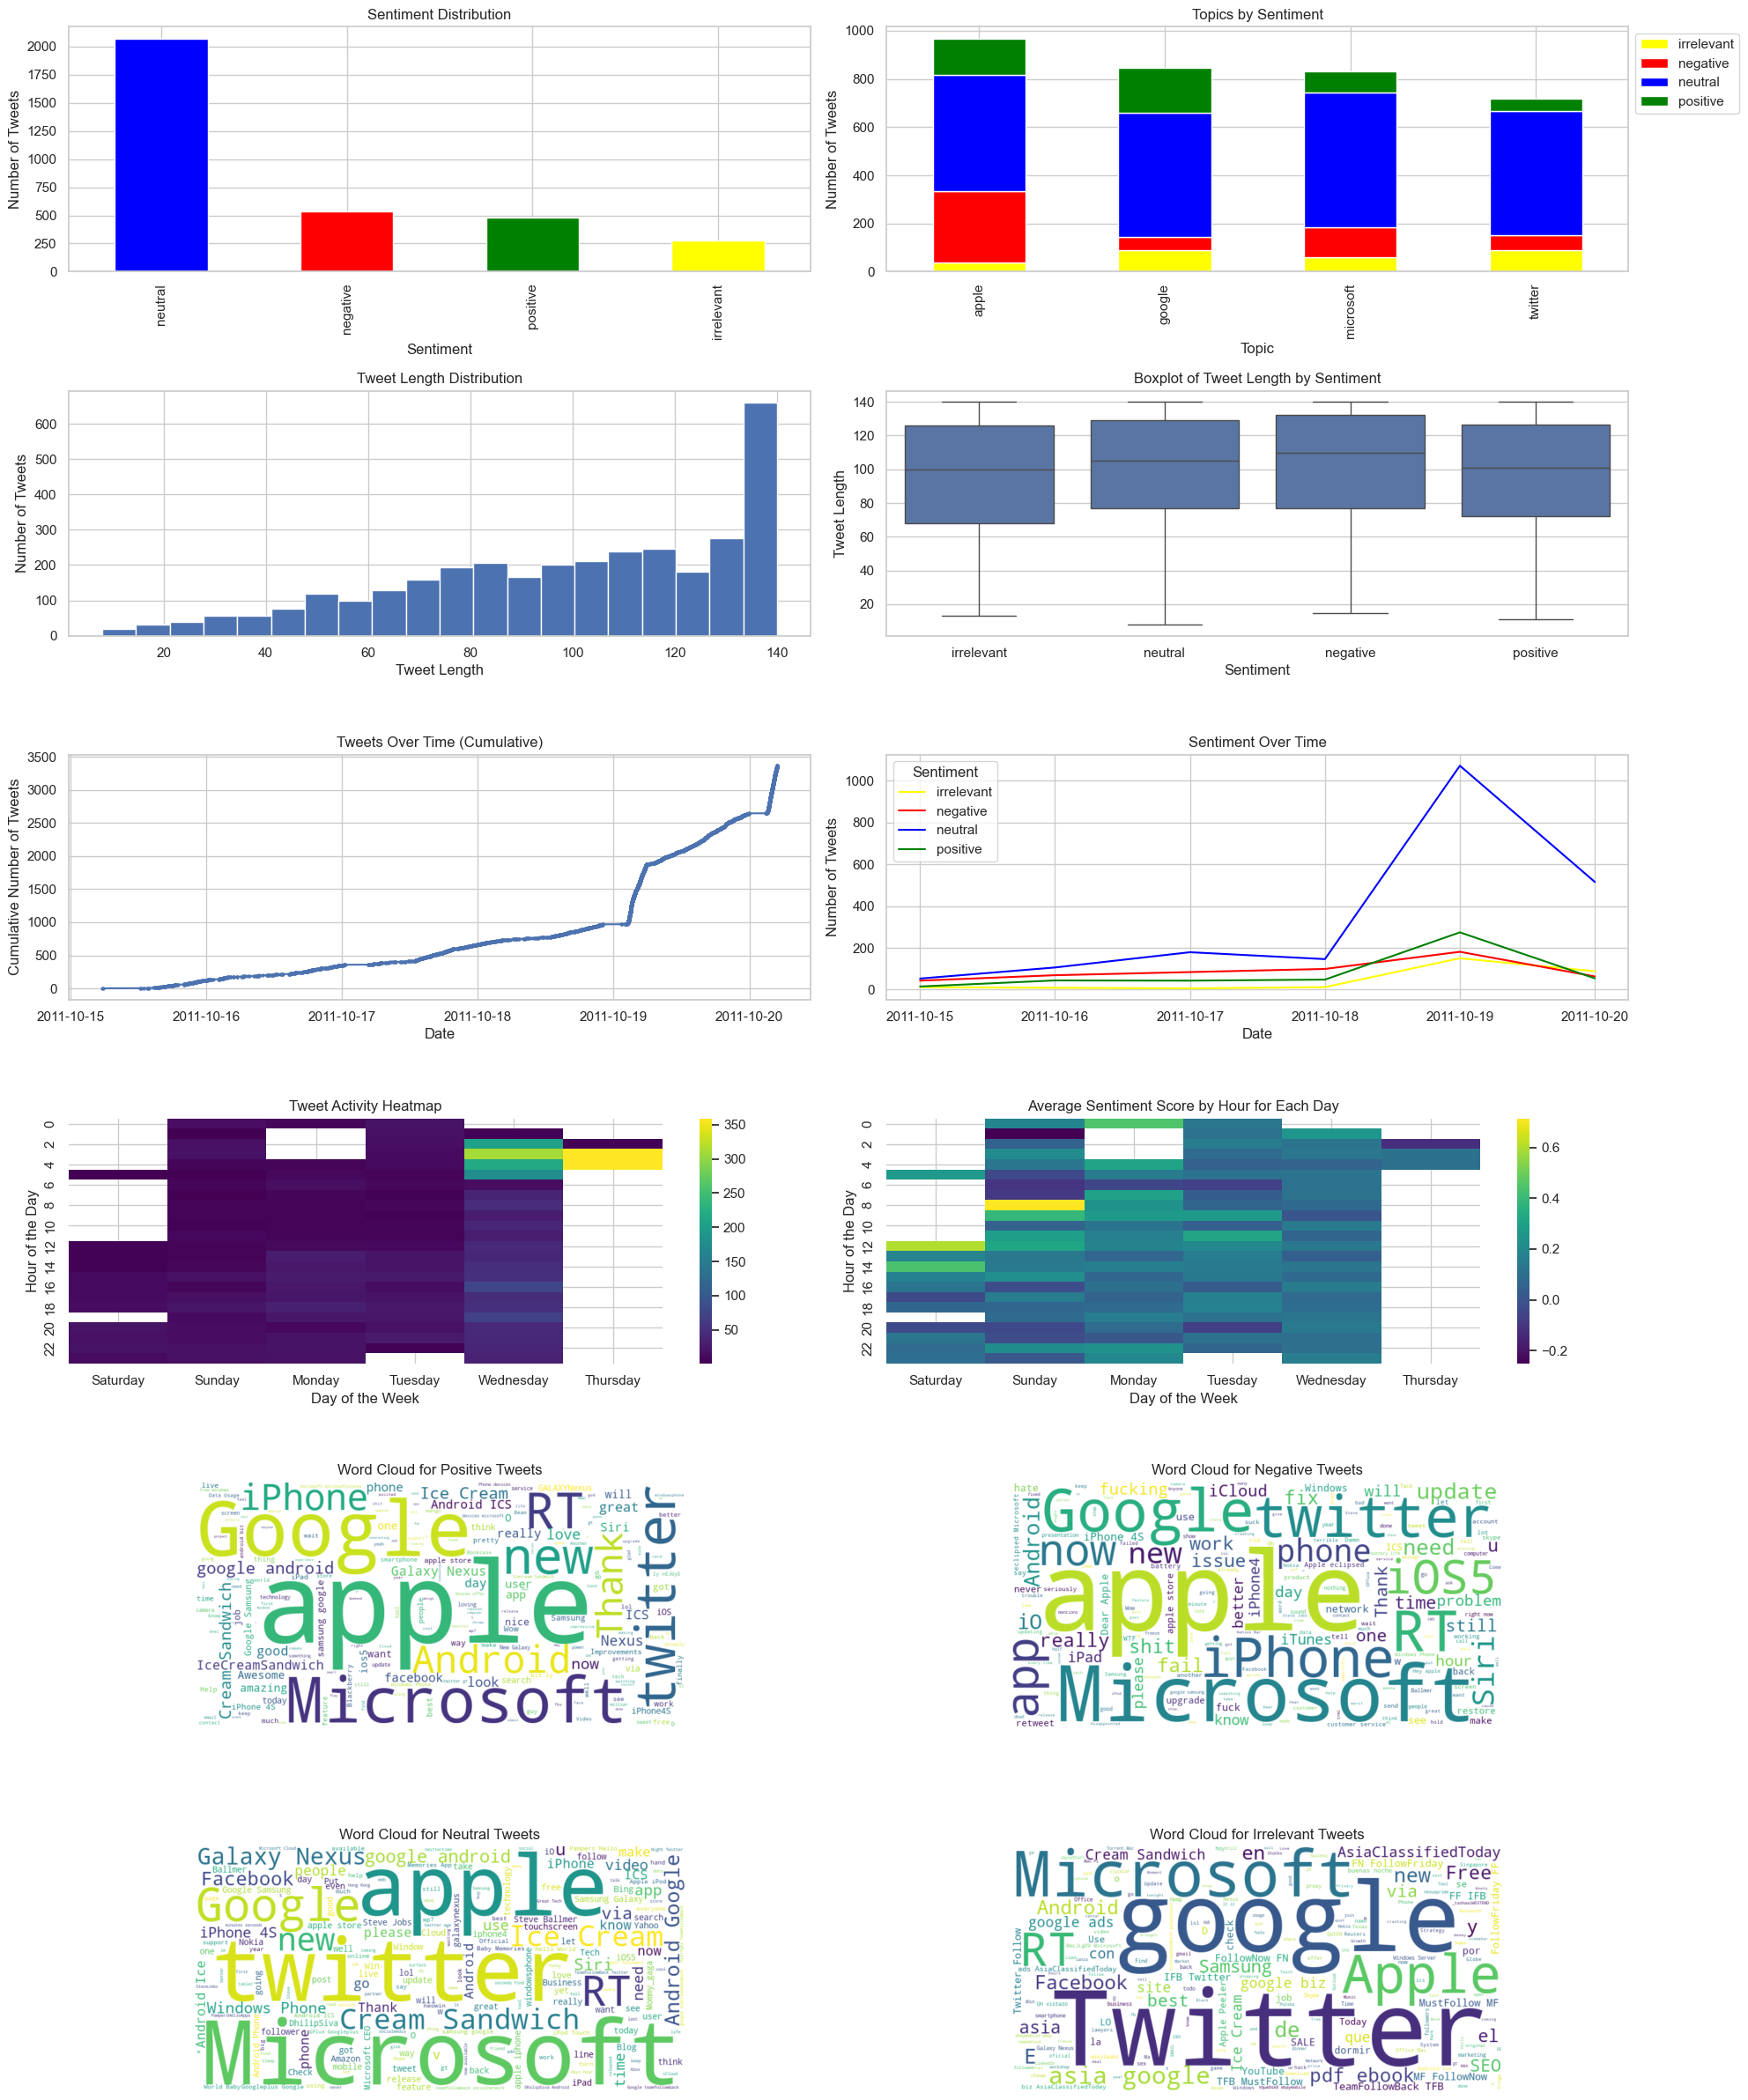

In [36]:
# Sum Up Total Number of Tweets
total_tweets = df_english_tweets.shape[0]
print(f"Total number of tweets: {total_tweets}")

# Confirm Stopwords
stopwords = set(STOPWORDS)
stopwords.update(['t', 'co', 'https'])
print(f"Stopwords confirmed: {', '.join(stopwords)}")

# Correct order for days
day_order = ['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday']

# Print Number of Tweets and Average Sentiment Score for Each Hour and Day
hourly_stats = df_english_tweets.groupby(['Day', 'Hour']).agg(
    tweet_count=('TweetId', 'size'),
    avg_sentiment=('SentimentScore', 'mean')
).reindex(day_order, level='Day')

print("\nNumber of Tweets and Average Sentiment Score for Each Hour and Day:")
print(hourly_stats)

plt.figure(figsize=(20, 24))

# Plot 1: Sentiment Distribution
plt.subplot(6, 2, 1)
sentiment_counts = df_english_tweets['Sentiment'].value_counts()
sentiment_counts.plot(kind='bar', color=['blue', 'red', 'green', 'yellow'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')

# Plot 2: Topics by Sentiment
plt.subplot(6, 2, 2)
colors = {'positive': 'green', 'negative': 'red', 'neutral': 'blue', 'irrelevant': 'yellow'}
topic_sentiment_counts = df_english_tweets.groupby(['Topic', 'Sentiment']).size().unstack()
topic_sentiment_counts.plot(kind='bar', stacked=True, ax=plt.gca(), color=[colors[col] for col in topic_sentiment_counts.columns])
plt.title('Topics by Sentiment')
plt.xlabel('Topic')
plt.ylabel('Number of Tweets')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Plot 3: Tweet Length Distribution
plt.subplot(6, 2, 3)
df_english_tweets['TweetLength'].hist(bins=20)
plt.title('Tweet Length Distribution')
plt.xlabel('Tweet Length')
plt.ylabel('Number of Tweets')

# Plot 4: Boxplot of Tweet Length by Sentiment
plt.subplot(6, 2, 4)
sns.boxplot(x='Sentiment', y='TweetLength', data=df_english_tweets)
plt.title('Boxplot of Tweet Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Tweet Length')

# Plot 5: Tweets Over Time (Cumulative Line Plot)
plt.subplot(6, 2, 5)
df_english_tweets['CumulativeTweetCount'] = df_english_tweets.sort_values(by='TweetDate').reset_index().index + 1
plt.plot(df_english_tweets['TweetDate'], df_english_tweets['CumulativeTweetCount'], linestyle='-', marker='o', markersize=2)
plt.title('Tweets Over Time (Cumulative)')
plt.xlabel('Date')
plt.ylabel('Cumulative Number of Tweets')

# Plot 6: Sentiment Over Time (Line Plot)
plt.subplot(6, 2, 6)
sentiments_over_time = df_english_tweets.pivot_table(index=df_english_tweets['TweetDate'].dt.date, columns='Sentiment', aggfunc='size', fill_value=0)
sentiments_over_time.plot(kind='line', ax=plt.gca(), color=['yellow', 'red', 'blue', 'green'])
plt.title('Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')

# Plot 7: Tweet Activity Heatmap
plt.subplot(6, 2, 7)
tweet_activity = df_english_tweets.groupby(['Day', 'Hour']).size().unstack().reindex(day_order)
sns.heatmap(tweet_activity.T, cmap='viridis')
plt.title('Tweet Activity Heatmap')
plt.xlabel('Day of the Week')
plt.ylabel('Hour of the Day')

# Plot 8: Average Sentiment Score by Hour for Each Day
plt.subplot(6, 2, 8)
avg_sentiment_by_hour_day = df_english_tweets.groupby(['Day', 'Hour'])['SentimentScore'].mean().unstack()
avg_sentiment_by_hour_day = avg_sentiment_by_hour_day.reindex(day_order)
sns.heatmap(avg_sentiment_by_hour_day.T, cmap='viridis')
plt.title('Average Sentiment Score by Hour for Each Day')
plt.xlabel('Day of the Week')
plt.ylabel('Hour of the Day')

# Plot 9: Word Cloud for Positive Sentiment
plt.subplot(6, 2, 9)
positive_text = ' '.join(df_english_tweets[df_english_tweets['Sentiment'] == 'positive']['TweetText'])
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(positive_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Tweets')

# Plot 10: Word Cloud for Negative Sentiment
plt.subplot(6, 2, 10)
negative_text = ' '.join(df_english_tweets[df_english_tweets['Sentiment'] == 'negative']['TweetText'])
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(negative_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Tweets')

# Plot 11: Word Cloud for Neutral Sentiment
plt.subplot(6, 2, 11)
neutral_text = ' '.join(df_english_tweets[df_english_tweets['Sentiment'] == 'neutral']['TweetText'])
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(neutral_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Neutral Tweets')

# Plot 12: Word Cloud for Irrelevant Sentiment
plt.subplot(6, 2, 12)
irrelevant_text = ' '.join(df_english_tweets[df_english_tweets['Sentiment'] == 'irrelevant']['TweetText'])
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(irrelevant_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Irrelevant Tweets')

plt.tight_layout()
plt.show()

## Analysis

In this section, I will analyze the dataset to uncover trends and patterns, providing deeper insights.

Steps involved in the analysis:
- Descriptive Statistics of Sentiment Scores
- Sentiment Distribution and Normality Test
- Sentiment Variability Across Topics
- Regression Analysis of Tweet Length and Sentiment Score
- Chi-Square Test for Sentiment Distribution Independence

Mean Sentiment Score: 0.1100876297969602
Median Sentiment Score: 0.0
Standard Deviation of Sentiment Score: 0.3068157166680939


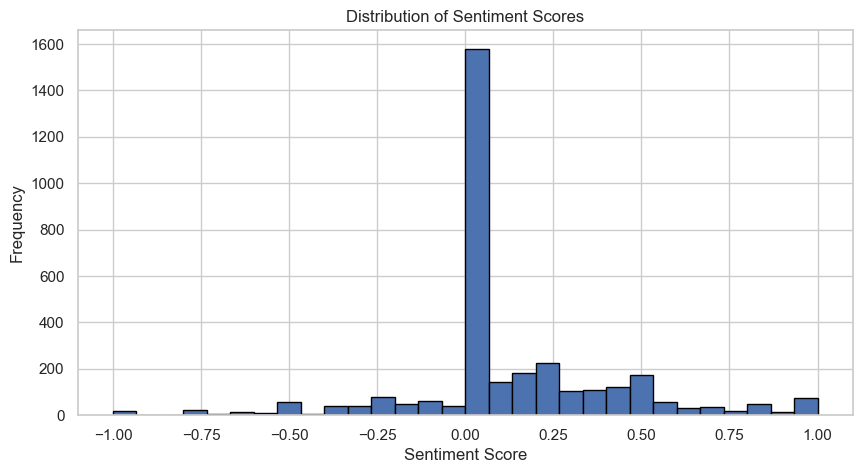

Shapiro-Wilk Test: W=0.884379075597395, p-value=1.2222400387007895e-44
The sentiment scores are not normally distributed (p < 0.05).

ANOVA Table for Sentiment Scores by Topic:
              sum_sq      df         F   PR(>F)
C(Topic)    0.068291     3.0  0.241655  0.86731
Residual  316.510687  3360.0       NaN      NaN

Regression Analysis Summary:
                            OLS Regression Results                            
Dep. Variable:         SentimentScore   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     24.99
Date:                Tue, 30 Jul 2024   Prob (F-statistic):           6.04e-07
Time:                        11:58:31   Log-Likelihood:                -785.76
No. Observations:                3364   AIC:                             1576.
Df Residuals:                    3362   BIC:                             1588.
Df Model:        

In [35]:
# Step 1: Descriptive Statistics of Sentiment Scores
sentiment_scores = df_english_tweets['SentimentScore']
mean_score = sentiment_scores.mean()
median_score = sentiment_scores.median()
std_score = sentiment_scores.std()

print(f"Mean Sentiment Score: {mean_score}")
print(f"Median Sentiment Score: {median_score}")
print(f"Standard Deviation of Sentiment Score: {std_score}")

# Step 2: Sentiment Distribution and Normality Test
# Histogram of sentiment scores
plt.figure(figsize=(10, 5))
plt.hist(sentiment_scores, bins=30, edgecolor='black')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

# Normality test using Shapiro-Wilk test
shapiro_test = stats.shapiro(sentiment_scores)
print(f"Shapiro-Wilk Test: W={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")
if shapiro_test.pvalue < 0.05:
    print("The sentiment scores are not normally distributed (p < 0.05).")
else:
    print("The sentiment scores are normally distributed (p >= 0.05).")

# Step 3: Sentiment Variability Across Topics
anova = ols('SentimentScore ~ C(Topic)', data=df_english_tweets).fit()
anova_table = sm.stats.anova_lm(anova, typ=2)
print("\nANOVA Table for Sentiment Scores by Topic:")
print(anova_table)

# Step 4: Regression Analysis of Tweet Length and Sentiment Score
X = df_english_tweets['TweetLength']
y = df_english_tweets['SentimentScore']
X = sm.add_constant(X)  # Adds a constant term to the predictor

model = sm.OLS(y, X).fit()
print("\nRegression Analysis Summary:")
print(model.summary())

# Step 5: Chi-Square Test for Sentiment Distribution Independence
contingency_table = pd.crosstab(df_english_tweets['Topic'], df_english_tweets['Sentiment'])
chi2, p, dof, ex = stats.chi2_contingency(contingency_table)
print("\nChi-Square Test for Sentiment Distribution Independence:")
print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")

if p < 0.05:
    print("There is a significant relationship between topic and sentiment distribution (p < 0.05).")
else:
    print("There is no significant relationship between topic and sentiment distribution (p >= 0.05).")

# Findings and Recommendations

This section presents the key insights derived from both visualizations and statistical analysis, followed by recommendations to address potential biases and improve data interpretation.

## Findings from Visualizations:

1. **Sentiment Distribution:**
   - **Plot**: Sentiment distribution bar plot
   - **Observation**: Neutral tweets dominate, with fewer positive, negative, and irrelevant tweets, indicating a potential selection bias.

2. **Tweet Length:**
   - **Plot**: Tweet length distribution histogram and boxplot of tweet length by sentiment
   - **Observation**: Tweets often reach the 140-character limit, which is expected due to Twitter's constraints, providing limited additional insight. The boxplot shows that tweet length is relatively consistent across different sentiments.

3. **Tweets Over Time:**
   - **Plots**: Cumulative tweet count plot and sentiment over time line plot
   - **Observation**: Activity spikes correlate with specific events, requiring correlation with real-world events for deeper understanding. The sentiment over time plot shows fluctuations in sentiment, which may align with significant events.

4. **Hourly Sentiment Trends:**
   - **Plots**: Tweet activity heatmap and average sentiment score heatmap
   - **Observation**: Sentiment scores vary throughout the day, influenced by user demographics and time zones. The tweet activity heatmap shows higher activity during certain hours, while the average sentiment score heatmap highlights variations in sentiment at different times.

5. **Word Clouds:**
   - **Plots**: Word clouds for positive, negative, neutral, and irrelevant tweets
   - **Observation**: Common words differ by sentiment category, providing insight into the language and topics associated with each sentiment.

## Findings from Statistical Analysis:

1. **Descriptive Statistics of Sentiment Scores:**
   - **Result**: Mean sentiment score is 0.11, median is 0.0, and standard deviation is 0.31.
   - **Observation**: Neutral sentiment scores are most common, indicating a central tendency around neutrality.

2. **Normality Test:**
   - **Result**: Shapiro-Wilk test shows sentiment scores are not normally distributed (p < 0.05).
   - **Observation**: The distribution is skewed, indicating non-normality and potential bias in the sentiment data.

3. **ANOVA for Sentiment Scores by Topic:**
   - **Result**: No significant variability across topics (p = 0.867).
   - **Observation**: Sentiment scores are consistent across different topics, suggesting uniform sentiment distribution or potential categorization issues.

4. **Regression Analysis of Tweet Length and Sentiment Score:**
   - **Result**: Small but significant positive correlation (R-squared = 0.007, p < 0.05).
   - **Observation**: The relationship between tweet length and sentiment score is statistically significant but practically negligible, raising questions about its real-world relevance.

5. **Chi-Square Test for Sentiment Distribution Independence:**
   - **Result**: Significant relationship between topic and sentiment distribution (p < 0.05).
   - **Observation**: Some topics have distinct sentiment profiles, suggesting underlying trends or biases in sentiment based on the topic.

## Recommendations

Given the potential biases and limitations of the dataset, the following recommendations are proposed:

1. **Dataset Quality Assessment:**
    - **Observation**: The criteria for tweet selection and topic categorization may introduce biases, affecting the representativeness of the dataset.
    - **Recommendation**: Critically assess the dataset for biases and quality issues before making any conclusions.

2. **Contextual Analysis:**
    - **Observation**: Spikes in tweet activity likely correlate with real-world events, which are not currently accounted for in the analysis.
    - **Recommendation**: Correlate tweet activity and sentiment with real-world events to provide context to the data.

3. **Extended Data Collection:**
    - **Observation**: The dataset lacks metadata such as user demographics, tweet sources, and geographic information, which could provide deeper insights.
    - **Recommendation**: Collect additional data to validate findings and ensure a more comprehensive analysis.

4. **Bias Detection:**
    - **Observation**: Potential biases exist in the dataset, which may affect the validity of the analysis.
    - **Recommendation**: Implement methods to detect and mitigate biases in the dataset.

5. **Holistic Analysis:**
    - **Observation**: Relying solely on initial findings without considering multiple factors can lead to incomplete conclusions.
    - **Recommendation**: Take a broader view of the data, considering multiple factors and potential biases, rather than relying solely on initial findings.

6. **Continuous Monitoring:**
    - **Observation**: Trends and patterns in tweet activity and sentiment can change over time, necessitating ongoing analysis.
    - **Recommendation**: Implement ongoing monitoring and analysis to detect changes and trends over time.